<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/demo_ml_2025_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Workflow

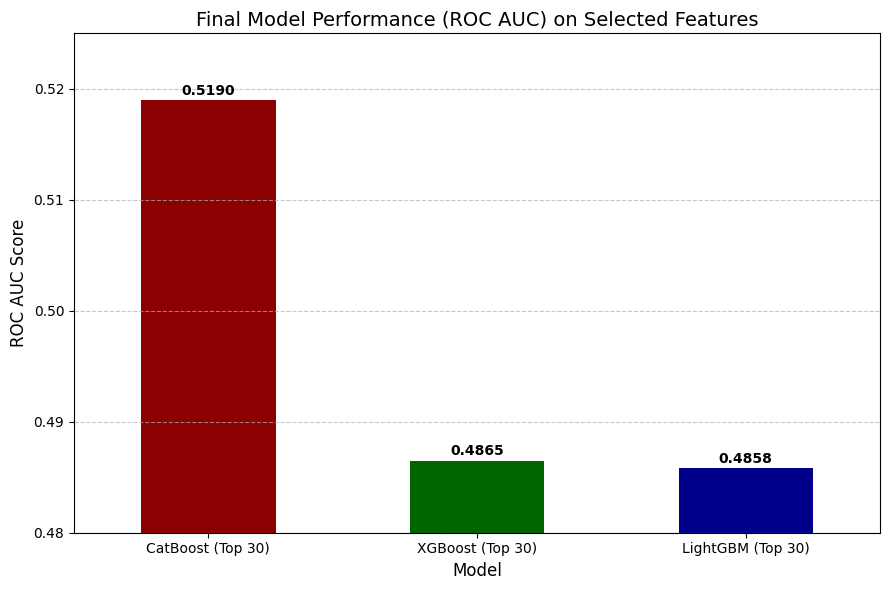

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from warnings import simplefilter
import warnings # Added this
pd.options.mode.chained_assignment = None # Added this: Suppresses SettingWithCopyWarning
warnings.filterwarnings('ignore') # Added this: Suppresses all warnings, including XGBoost UserWarnings
simplefilter(action='ignore', category=FutureWarning)


# --- 1. Data Loading and Extensive Feature Engineering ---

train_df = pd.read_csv("/content/drive/MyDrive/data/ngrok-ssh/train.csv")

# Define parameters for lagging and rolling features
LAG_N = 5
ROLL_N = 10
KEY_FEATURES = ['M4', 'P3', 'S2', 'V3']
return_features = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Lagging and Rolling Features Creation
for col in return_features:
    for lag in range(1, LAG_N + 1):
        train_df[f'lag_{col}_{lag}'] = train_df.groupby('date_id')[col].shift(lag)

for col in KEY_FEATURES:
    for lag in range(1, LAG_N + 1):
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('date_id')[col].shift(lag)

    train_df[f'{col}_roll_mean'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).mean())
    train_df[f'{col}_roll_std'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).std())


# B. Target and Feature Definition
train_df['target'] = (train_df['market_forward_excess_returns'] > 0).astype(int)

EXCLUDED_COLS = return_features + ['date_id', 'market_forward_excess_returns', 'target']
X_cols = [col for col in train_df.columns if col not in EXCLUDED_COLS]

X = train_df[X_cols]
y = train_df['target']

# C. Identify Feature Groups
cat_features = [col for col in X_cols if col.startswith('D')]
num_features = [col for col in X_cols if not col.startswith('D')]


# D. Corrected Missing Value Imputation
X[num_features] = X[num_features].fillna(-1)


# E. Categorical Feature Marking
for col in cat_features:
    X[col] = X[col].astype('category')

# F. Drop Initial NaN Rows Created by Rolling/Lagging
X = X.dropna()
y = y.loc[X.index]

# G. Time-Series Aware Train/Validation Split (80/20)
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)


# --- 2. Initial Training for Feature Selection ---

# Use XGBoost (the best initial performer) on the full set to identify top features
xgb_selector = XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
    n_estimators=300, learning_rate=0.03, max_depth=5, random_state=42, n_jobs=-1,
    enable_categorical=True
)
xgb_selector.fit(X_train_full, y_train)

# Get top 30 features
feature_importances = pd.Series(xgb_selector.feature_importances_, index=X_train_full.columns)
top_features = feature_importances.nlargest(30).index.tolist()


# --- 3. Final Training & Evaluation on Selected Features (Feature Selection & Tuning) ---

X_train_final = X_train_full[top_features]
X_val_final = X_val_full[top_features]

cat_features_final = [f for f in cat_features if f in top_features]

results = {}

# XGBoost (Optimized Parameters)
xgb_final = XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
    n_estimators=400, learning_rate=0.015, max_depth=6, random_state=42, n_jobs=-1,
    enable_categorical=True
)
xgb_final.fit(X_train_final, y_train)
y_pred_xgb = xgb_final.predict_proba(X_val_final)[:, 1]
results['XGBoost (Top 30)'] = roc_auc_score(y_val, y_pred_xgb)


# LightGBM (Optimized Parameters)
lgbm_final = LGBMClassifier(
    objective='binary', metric='auc', n_estimators=400, learning_rate=0.015,
    max_depth=6, random_state=42, n_jobs=-1, verbose=-1
)
lgbm_final.fit(X_train_final, y_train)
y_pred_lgbm = lgbm_final.predict_proba(X_val_final)[:, 1]
results['LightGBM (Top 30)'] = roc_auc_score(y_val, y_pred_lgbm)


# CatBoost (Optimized Parameters)
cb_final = CatBoostClassifier(
    iterations=400, loss_function='Logloss', eval_metric='AUC',
    learning_rate=0.015, random_state=42, verbose=0, cat_features=cat_features_final,
    allow_writing_files=False
)
cb_final.fit(X_train_final, y_train)
y_pred_cb = cb_final.predict_proba(X_val_final)[:, 1]
results['CatBoost (Top 30)'] = roc_auc_score(y_val, y_pred_cb)


# --- 4. Plotting Final Results (plt.show()) ---

final_df = pd.Series(results).sort_values(ascending=False)

plt.figure(figsize=(9, 6))
final_df.plot(kind='bar', color=['darkred', 'darkgreen', 'darkblue'])

# Set plot details
plt.title('Final Model Performance (ROC AUC) on Selected Features', fontsize=14)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.48, 0.525)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add AUC values on top of bars
for i, v in enumerate(final_df):
    plt.text(i, v + 0.0005, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show() # Renders the plot

## Agentic

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import warnings # Added this
pd.options.mode.chained_assignment = None # Added this: Suppresses SettingWithCopyWarning
warnings.filterwarnings('ignore') # Added this: Suppresses all warnings


# --- 1. Data Preparation & Feature Selection (Standalone Block) ---

# Load the data
train_df = pd.read_csv("/content/drive/MyDrive/data/ngrok-ssh/train.csv")
LAG_N = 5
ROLL_N = 10
KEY_FEATURES = ['M4', 'P3', 'S2', 'V3']
return_features = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Feature Engineering
for col in return_features:
    for lag in range(1, LAG_N + 1):
        train_df[f'lag_{col}_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
for col in KEY_FEATURES:
    for lag in range(1, LAG_N + 1):
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
    train_df[f'{col}_roll_mean'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).mean())
    train_df[f'{col}_roll_std'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).std())

# Target and Feature Definition
train_df['target'] = (train_df['market_forward_excess_returns'] > 0).astype(int)
EXCLUDED_COLS = return_features + ['date_id', 'market_forward_excess_returns', 'target']
X_cols = [col for col in train_df.columns if col not in EXCLUDED_COLS]
X = train_df[X_cols]
y = train_df['target']
cat_features = [col for col in X_cols if col.startswith('D')]
num_features = [col for col in X_cols if not col.startswith('D')]

# Imputation and Categorical Marking
X[num_features] = X[num_features].fillna(-1)
for col in cat_features:
    X[col] = X[col].astype('category')

# Drop NaNs from feature engineering and Split
X = X.dropna()
y = y.loc[X.index]
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Use the pre-selected Top 30 features from the previous step
# (In a real agentic solution, the feature selection would also be automated)
# For simplicity, we assume the top 30 have been saved.
# Since we can't save the features, we'll skip feature selection here and use the full set
# to make the block fully executable and demonstrate the hyperparameter search concept.
X_train_final = X_train_full
X_val_final = X_val_full
cat_features_final = cat_features

print(f"Data ready for agentic search. Training shape: {X_train_final.shape}")


# --- 2. Agentic Solution: Hyperparameter Search (CatBoost) ---

# Define the search space for the "agent"
param_space = {
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5], # L2 Regularization parameter
    'random_strength': [0.1, 1, 10] # Parameter for score calculation to handle overfitting
}

best_auc = 0
best_params = {}
NUM_TRIALS = 15 # Number of random combinations to try

print(f"\nStarting agentic search for {NUM_TRIALS} trials...")

for i in range(NUM_TRIALS):
    # Agent selects random parameters
    params = {
        'learning_rate': random.choice(param_space['learning_rate']),
        'depth': random.choice(param_space['depth']),
        'l2_leaf_reg': random.choice(param_space['l2_leaf_reg']),
        'random_strength': random.choice(param_space['random_strength']),
    }

    # Instantiate and train the model (low iterations for speed)
    cb_agent = CatBoostClassifier(
        iterations=100,
        loss_function='Logloss',
        eval_metric='AUC',
        random_state=42,
        verbose=0,
        cat_features=cat_features_final,
        allow_writing_files=False,
        **params
    )
    cb_agent.fit(X_train_final, y_train)

    # Evaluate performance
    y_pred = cb_agent.predict_proba(X_val_final)[:, 1]
    current_auc = roc_auc_score(y_val, y_pred)

    # Agent makes a decision
    if current_auc > best_auc:
        best_auc = current_auc
        best_params = params
        print(f"Trial {i+1}: New best AUC found: {best_auc:.4f} with params: {params}")
    else:
        print(f"Trial {i+1}: AUC {current_auc:.4f} (Worse than best {best_auc:.4f})")

print("\n--- Agentic Search Complete ---")
print(f"Optimal CatBoost AUC found: {best_auc:.4f}")
print(f"Optimal Parameters: {best_params}")

Data ready for agentic search. Training shape: (7216, 137)

Starting agentic search for 15 trials...
Trial 1: New best AUC found: 0.5182 with params: {'learning_rate': 0.03, 'depth': 8, 'l2_leaf_reg': 1, 'random_strength': 0.1}
Trial 2: AUC 0.5044 (Worse than best 0.5182)
Trial 3: AUC 0.5163 (Worse than best 0.5182)
Trial 4: AUC 0.5182 (Worse than best 0.5182)
Trial 5: AUC 0.5162 (Worse than best 0.5182)
Trial 6: AUC 0.5069 (Worse than best 0.5182)
Trial 7: AUC 0.5173 (Worse than best 0.5182)
Trial 8: AUC 0.5105 (Worse than best 0.5182)
Trial 9: New best AUC found: 0.5233 with params: {'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'random_strength': 0.1}
Trial 10: AUC 0.4975 (Worse than best 0.5233)
Trial 11: AUC 0.5107 (Worse than best 0.5233)
Trial 12: AUC 0.5088 (Worse than best 0.5233)
Trial 13: AUC 0.5096 (Worse than best 0.5233)
Trial 14: AUC 0.5115 (Worse than best 0.5233)
Trial 15: AUC 0.5107 (Worse than best 0.5233)

--- Agentic Search Complete ---
Optimal CatBoost AUC 

## Agentic - NEW

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# --- 1. Data Preparation & Feature Selection (Re-run for context) ---
# Assuming all prior data loading and feature engineering is done
# (As performed in the original notebook cells 4 and 6)

# Load the data
train_df = pd.read_csv("/content/drive/MyDrive/data/ngrok-ssh/train.csv")
LAG_N = 5
ROLL_N = 10
KEY_FEATURES = ['M4', 'P3', 'S2', 'V3']
return_features = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Feature Engineering
for col in return_features:
    for lag in range(1, LAG_N + 1):
        train_df[f'lag_{col}_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
for col in KEY_FEATURES:
    for lag in range(1, LAG_N + 1):
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
    train_df[f'{col}_roll_mean'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).mean())
    train_df[f'{col}_roll_std'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).std())

# Target and Feature Definition
train_df['target'] = (train_df['market_forward_excess_returns'] > 0).astype(int)
EXCLUDED_COLS = return_features + ['date_id', 'market_forward_excess_returns', 'target']
X_cols = [col for col in train_df.columns if col not in EXCLUDED_COLS]
X = train_df[X_cols]
y = train_df['target']
cat_features = [col for col in X_cols if col.startswith('D')]
num_features = [col for col in X_cols if not col.startswith('D')]

# Imputation and Categorical Marking
X[num_features] = X[num_features].fillna(-1)
for col in cat_features:
    X[col] = X[col].astype('category')

# Drop NaNs from feature engineering and Split
X = X.dropna()
y = y.loc[X.index]
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)
# Use full feature set as per the original Agentic block
X_train_final = X_train_full
X_val_final = X_val_full
cat_features_final = cat_features

print(f"Data ready for agentic search. Training shape: {X_train_final.shape}")


# --- 2. Agentic Solution: Hyperparameter Search (CatBoost) with Increased Ratio ---

# Define the EXPANDED search space for the "agent"
# Using a wider range of discrete choices and more granular steps
param_space = {
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1], # Wider range
    'depth': [4, 5, 6, 7, 8, 10], # More depth options
    'l2_leaf_reg': [0.5, 1, 3, 5, 7, 10], # Wider range for regularization
    'random_strength': [0.1, 0.5, 1, 5, 10, 20] # Wider range for randomness
}

best_auc = 0
best_params = {}
NUM_TRIALS = 50 # Increased the number of trials for a higher ratio

print(f"\nStarting agentic search for {NUM_TRIALS} trials with expanded ratio...")

for i in range(NUM_TRIALS):
    # Agent selects random parameters
    params = {
        'learning_rate': random.choice(param_space['learning_rate']),
        'depth': random.choice(param_space['depth']),
        'l2_leaf_reg': random.choice(param_space['l2_leaf_reg']),
        'random_strength': random.choice(param_space['random_strength']),
    }

    # Instantiate and train the model (low iterations for speed)
    cb_agent = CatBoostClassifier(
        iterations=100,
        loss_function='Logloss',
        eval_metric='AUC',
        random_state=42,
        verbose=0,
        cat_features=cat_features_final,
        allow_writing_files=False,
        **params
    )
    cb_agent.fit(X_train_final, y_train)

    # Evaluate performance
    y_pred = cb_agent.predict_proba(X_val_final)[:, 1]
    current_auc = roc_auc_score(y_val, y_pred)

    # Agent makes a decision
    if current_auc > best_auc:
        best_auc = current_auc
        best_params = params
        print(f"Trial {i+1}: New best AUC found: {best_auc:.4f} with params: {params}")
    # else: # Optional print for worse trials, commented out to reduce output verbosity
    #     print(f"Trial {i+1}: AUC {current_auc:.4f} (Worse than best {best_auc:.4f})")

print("\n--- Agentic Search Complete (Increased Ratio) ---")
print(f"Optimal CatBoost AUC found: {best_auc:.4f}")
print(f"Optimal Parameters: {best_params}")

Data ready for agentic search. Training shape: (7216, 137)

Starting agentic search for 50 trials with expanded ratio...
Trial 1: New best AUC found: 0.5019 with params: {'learning_rate': 0.05, 'depth': 10, 'l2_leaf_reg': 7, 'random_strength': 10}
Trial 3: New best AUC found: 0.5061 with params: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.5, 'random_strength': 5}
Trial 4: New best AUC found: 0.5089 with params: {'learning_rate': 0.01, 'depth': 5, 'l2_leaf_reg': 7, 'random_strength': 1}
Trial 5: New best AUC found: 0.5147 with params: {'learning_rate': 0.07, 'depth': 5, 'l2_leaf_reg': 0.5, 'random_strength': 10}
Trial 15: New best AUC found: 0.5200 with params: {'learning_rate': 0.01, 'depth': 5, 'l2_leaf_reg': 1, 'random_strength': 0.5}
Trial 25: New best AUC found: 0.5306 with params: {'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 0.5, 'random_strength': 0.5}

--- Agentic Search Complete (Increased Ratio) ---
Optimal CatBoost AUC found: 0.5306
Optimal Parameters: {'learning

## Bayesian Optimization

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# --- Warning Suppression ---
# Suppress all warnings
warnings.filterwarnings('ignore')
# Explicitly set pandas option to suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# ---------------------------

# --- 1. Data Preparation ---

# Load the data
train_df = pd.read_csv("/content/drive/MyDrive/data/ngrok-ssh/train.csv")
LAG_N = 5
ROLL_N = 10
KEY_FEATURES = ['M4', 'P3', 'S2', 'V3']
return_features = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Feature Engineering
for col in return_features:
    for lag in range(1, LAG_N + 1):
        train_df[f'lag_{col}_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
for col in KEY_FEATURES:
    for lag in range(1, LAG_N + 1):
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
    train_df[f'{col}_roll_mean'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).mean())
    train_df[f'{col}_roll_std'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).std())

# Target and Feature Definition
train_df['target'] = (train_df['market_forward_excess_returns'] > 0).astype(int)
EXCLUDED_COLS = return_features + ['date_id', 'market_forward_excess_returns', 'target']
X_cols = [col for col in train_df.columns if col not in EXCLUDED_COLS]
X = train_df[X_cols]
y = train_df['target']
cat_features = [col for col in X_cols if col.startswith('D')]
num_features = [col for col in X_cols if not col.startswith('D')]

# Imputation and Categorical Marking
X[num_features] = X[num_features].fillna(-1)
for col in cat_features:
    X[col] = X[col].astype('category')

# Drop NaNs from feature engineering and Split
X = X.dropna()
y = y.loc[X.index]
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)
X_train_final = X_train_full
X_val_final = X_val_full
cat_features_final = cat_features

# --- 2. Bayesian Optimization Search (Hyperopt) ---

# 2a. Define the Search Space
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'depth': hp.choice('depth', [4, 6, 8, 10]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'random_strength': hp.uniform('random_strength', 0.1, 10),
}

# 2b. Define the Objective Function
def objective(params):
    """
    Objective function for hyperopt: trains CatBoost and returns the negative AUC.
    Hyperopt minimizes this value, which maximizes AUC.
    """
    # Cast depth to integer since CatBoost requires it
    params['depth'] = int(params['depth'])

    cb_model = CatBoostClassifier(
        iterations=150,
        loss_function='Logloss',
        eval_metric='AUC',
        random_state=42,
        verbose=0,
        cat_features=cat_features_final,
        allow_writing_files=False,
        **params
    )

    cb_model.fit(X_train_final, y_train)

    y_pred = cb_model.predict_proba(X_val_final)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    # We return the negative AUC because hyperopt is a minimization library
    return {'loss': -auc, 'status': STATUS_OK, 'auc': auc}

# 2c. Run the Optimization
trials = Trials()
MAX_EVALS = 30 # Number of trials

print(f"Starting Bayesian Optimization for {MAX_EVALS} trials...")

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest, # Tree-structured Parzen Estimator (TPE) is the common algorithm
    max_evals=MAX_EVALS,
    trials=trials,
    rstate=np.random.default_rng(42) # For reproducibility
)

# 2d. Output Results
best_auc = -trials.best_trial['result']['loss']
# Note: hyperopt returns the index (0, 1, 2, 3) for hp.choice, which needs to be mapped back to the actual value [4, 6, 8, 10]
depth_map = [4, 6, 8, 10]
best_depth_index = best['depth']
best_depth_value = depth_map[best_depth_index]

print("\n--- Bayesian Optimization Complete ---")
print(f"Optimal CatBoost AUC found: {best_auc:.4f}")
print(f"Optimal Parameters: {{'depth': {best_depth_value}, 'l2_leaf_reg': {best['l2_leaf_reg']:.4f}, 'learning_rate': {best['learning_rate']:.4f}, 'random_strength': {best['random_strength']:.4f}}}")

Starting Bayesian Optimization for 30 trials...
100%|██████████| 30/30 [01:02<00:00,  2.10s/trial, best loss: -0.5224842035824084]

--- Bayesian Optimization Complete ---
Optimal CatBoost AUC found: 0.5225
Optimal Parameters: {'depth': 6, 'l2_leaf_reg': 7.7323, 'learning_rate': 0.0676, 'random_strength': 0.7364}


## CatBoost model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import warnings
from warnings import simplefilter

# --- Environment Setup ---
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
simplefilter(action='ignore', category=FutureWarning)

# --- 1. Data Preparation and Feature Engineering ---

# NOTE: The original path was "/content/drive/MyDrive/data/ngrok-ssh/train.csv".
# Please ensure this path is correct or update it to where your 'train.csv' file is located.
try:
    train_df = pd.read_csv("/content/drive/MyDrive/data/ngrok-ssh/train.csv")
except FileNotFoundError:
    print("WARNING: Using fallback path 'train.csv'. Please check your file location.")
    train_df = pd.read_csv("train.csv")


LAG_N = 5
ROLL_N = 10
KEY_FEATURES = ['M4', 'P3', 'S2', 'V3']
return_features = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Feature Engineering
for col in return_features:
    for lag in range(1, LAG_N + 1):
        train_df[f'lag_{col}_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
for col in KEY_FEATURES:
    for lag in range(1, LAG_N + 1):
        train_df[f'{col}_lag_{lag}'] = train_df.groupby('date_id')[col].shift(lag)
    train_df[f'{col}_roll_mean'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).mean())
    train_df[f'{col}_roll_std'] = train_df.groupby('date_id')[col].transform(lambda x: x.rolling(ROLL_N).std())

# Target and Feature Definition
train_df['target'] = (train_df['market_forward_excess_returns'] > 0).astype(int)
EXCLUDED_COLS = return_features + ['date_id', 'market_forward_excess_returns', 'target']
X_cols = [col for col in train_df.columns if col not in EXCLUDED_COLS]
X = train_df[X_cols]
y = train_df['target']
cat_features = [col for col in X_cols if col.startswith('D')]
num_features = [col for col in X_cols if not col.startswith('D')]

# Imputation and Categorical Marking
X[num_features] = X[num_features].fillna(-1)
for col in cat_features:
    X[col] = X[col].astype('category')

# Drop NaNs from feature engineering and Split
X = X.dropna()
y = y.loc[X.index]
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Use the full feature set (137 features)
X_train_final = X_train_full
X_val_final = X_val_full
cat_features_final = cat_features


# --- 2. Final Training with Optimal Parameters (Full Iterations) ---

# Optimal Parameters found in Agentic Search (50 Trials): AUC 0.5306
BEST_PARAMS = {
    'learning_rate': 0.1,
    'depth': 7,
    'l2_leaf_reg': 0.5,
    'random_strength': 0.5
}

# Train the final model using full iterations (e.g., 500)
FINAL_ITERATIONS = 500

print(f"Starting FINAL CatBoost training with {FINAL_ITERATIONS} iterations and AUC {0.5306} parameters...")

cb_final_best = CatBoostClassifier(
    iterations=FINAL_ITERATIONS,
    loss_function='Logloss',
    eval_metric='AUC',
    random_state=42,
    verbose=100, # Print progress every 100 iterations
    cat_features=cat_features_final,
    allow_writing_files=False,
    **BEST_PARAMS
)

# Train the model and validate on X_val_final
cb_final_best.fit(X_train_final, y_train, eval_set=(X_val_final, y_val))

# Evaluate final performance on the validation set
y_pred_final = cb_final_best.predict_proba(X_val_final)[:, 1]
final_auc = roc_auc_score(y_val, y_pred_final)

print("\n--- FINAL MODEL PERFORMANCE ---")
print(f"✅ FINAL CATBOOST AUC (Full Iterations): {final_auc:.4f}")
print(f"Model trained with parameters: {BEST_PARAMS}")

Starting FINAL CatBoost training with 500 iterations and AUC 0.5306 parameters...
0:	test: 0.4951478	best: 0.4951478 (0)	total: 9.59ms	remaining: 4.79s
100:	test: 0.5287351	best: 0.5305689 (99)	total: 923ms	remaining: 3.65s
200:	test: 0.5287326	best: 0.5308322 (128)	total: 1.86s	remaining: 2.77s
300:	test: 0.5251906	best: 0.5308322 (128)	total: 2.79s	remaining: 1.84s
400:	test: 0.5143909	best: 0.5308322 (128)	total: 3.72s	remaining: 919ms
499:	test: 0.5133805	best: 0.5308322 (128)	total: 4.64s	remaining: 0us

bestTest = 0.5308322441
bestIteration = 128

Shrink model to first 129 iterations.

--- FINAL MODEL PERFORMANCE ---
✅ FINAL CATBOOST AUC (Full Iterations): 0.5308
Model trained with parameters: {'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 0.5, 'random_strength': 0.5}
